## Import packages

In [1]:
import os
import glob as glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random

## Prepare list of images and masks to train

## Data Loader

##### collecting the train data folder for the images and masks and saving them in two variables 

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 1

input_dir = "/home/jupyter/AerialImageDataset/tiled/train_256/images"
target_dir = "/home/jupyter/AerialImageDataset/tiled/train_256/gt"

train_images = []
train_mask_images = []

for file in os.listdir(input_dir):
    if file[-3:] == 'jpg':
        
        path = os.path.join(input_dir, file)
        train_images.append(path)
        train_mask_images.append(path.replace('images','gt'))
        
    else:
        print(file)

##### collecting the validation data folder for the images and masks and saving them in two variables 

In [3]:
val_input_dir = "/home/jupyter/AerialImageDataset/tiled/validate_256/images"

val_images = []
val_mask_images = []

for file in os.listdir(val_input_dir):
    path = os.path.join(val_input_dir, file)
    val_images.append(path)
    val_mask_images.append(path.replace('images','gt'))

##### collecting the test data folder for the images and masks and saving them in two variables 

In [4]:
testing_input_dir = "/home/jupyter/AerialImageDataset/tiled/testing_256/images"

testing_images = []
testing_mask_images = []

for file in os.listdir(testing_input_dir):
    path = os.path.join(testing_input_dir, file)
    if ".ipynb" in path:
        continue
    testing_images.append(path)
    testing_mask_images.append(path.replace('images','gt'))

##### Creating reading function for reading and  storing all the files in imaging and masks in two variables

##### data loading function to load the read image and for the image nd the mask

###### creating data generator to slice over the full datasets files and create batches for both features and target in 1 variable for the model training 

In [5]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_jpeg(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image
    return image/255

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(buffer_size = 5000, reshuffle_each_iteration=True )
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    return dataset

train_dataset = data_generator(train_images, train_mask_images)
val_dataset = data_generator(val_images, val_mask_images)
testing_dataset = data_generator(testing_images, testing_mask_images)

print("Train Dataset:", testing_dataset)
#print("Val Dataset:", val_dataset)

2022-12-04 07:26:10.670841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 07:26:10.679864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 07:26:10.680136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 07:26:10.681041: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 1), dtype=tf.float32, name=None))>


### after the data generator the model input data are ready

## 1st UNet Model

In [6]:
img_size = (256,256,3)
num_classes = 1

In [ ]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

# vgg16 unit model

In [7]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256,256,3))
base_model.trainable = False ## Not trainable weights
 
def conv_block(last_layer, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(last_layer)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

block1 = base_model.get_layer("block1_conv2").output         ## (512 x 512)
block2 = base_model.get_layer("block2_conv2").output         ## (256 x 256)
block3 = base_model.get_layer("block3_conv3").output         ## (128 x 128)
block4 = base_model.get_layer("block4_conv3").output         ## (64 x 64)

bridge = base_model.get_layer("block5_conv3").output         ## (32 x 32)

x = Conv2DTranspose(512, (2, 2), strides=2, padding="same")(bridge)
x = Concatenate(axis=-1)([x, block4])
x = conv_block(x, 512)

x = Conv2DTranspose(256, (2, 2), strides=2, padding="same")(x)
x = Concatenate(axis=-1)([x, block3])
x = conv_block(x, 256)

x = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(x)
x = Concatenate(axis=-1)([x, block2])
x = conv_block(x, 128)

x = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(x)
x = Concatenate(axis=-1)([x, block1])
x = conv_block(x, 64)


outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

VGG16_model = Model((base_model.inputs), outputs, name="base_model_U-Net")
VGG16_model.summary()

Model: "base_model_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                  

##### defining the checkpoint and complie parameters

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU, BinaryIoU
es = EarlyStopping(patience = 8, restore_best_weights= True, verbose = 1)
iou = BinaryIoU(target_class_ids = [1], threshold=0.5)
mcp_simple = ModelCheckpoint('simple_checkpoint_model.h5', save_best_only = True)
mcp_VGG16 = ModelCheckpoint('VGG16_checkpoint_model.h5', save_best_only = True)
mcp_VGG16_enh = ModelCheckpoint('VGG16_checkpoint_model_enh.h5', save_best_only = True, verbose = 1)
mcp_VGG16_enh_02 = ModelCheckpoint('VGG16_checkpoint_model_enh_02.h5', save_best_only = True, verbose = 1)

defining the compined loss function

In [9]:
from tensorflow.keras.metrics import MeanIoU, BinaryIoU

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)

        return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

# VGG16 MODEL COMPLIE AND FITTING

In [ ]:
# VGG16_model.compile(loss = loss, optimizer = 'adam', metrics = [iou,'accuracy'])
# VGG16_model_history = VGG16_model.fit(train_dataset, callbacks = [es, mcp_VGG16], epochs=25, validation_data = val_dataset, batch_size=16)
# VGG16_model.save('VGG16_model_full.h5')

Epoch 1/25
3375/3375 [==============================] - 2659s 785ms/step - loss: 1.3725 - binary_io_u_4: 0.5983 - accuracy: 0.9160 - val_loss: 1.4016 - val_binary_io_u_4: 0.6369 - val_accuracy: 0.9339
Epoch 2/25
1433/3375 [===========>..................] - ETA: 23:35 - loss: 1.3634 - binary_io_u_4: 0.6443 - accuracy: 0.9262

# SIMPLE MODEL COMPLIE AND FITTING

In [ ]:
# model.compile(loss = loss, optimizer = 'adam', metrics = [iou,'accuracy'])
# model_history = model.fit(train_dataset, callbacks = [es, mcp_simple], epochs=25, validation_data = val_dataset, batch_size=16)
# model.save('model_full.h5')

# Enhanced VGG16 Model Compile and fitting

In [21]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import CSVLogger

# ROP = ReduceLROnPlateau(patience=3, min_lr=0.000001, verbose=1)
# CSVL = CSVLogger('VGG16_model_full_Enhanced_log.csv')

In [25]:
# VGG16_model.compile(loss = loss, optimizer = 'adam', metrics = [iou,'accuracy'])
# VGG16_model_history = VGG16_model.fit(train_dataset, callbacks = [es, mcp_VGG16_enh, ROP, CSVL], epochs=25, validation_data = val_dataset, batch_size=16)
# VGG16_model.save('VGG16_model_full_Enhanced.h5')

Epoch 1/25
3375/3375 [==============================] - ETA: 0s - loss: 1.3722 - binary_io_u_2: 0.5995 - accuracy: 0.9164
Epoch 1: val_loss improved from inf to 1.40170, saving model to VGG16_checkpoint_model_enh.h5
3375/3375 [==============================] - 2644s 783ms/step - loss: 1.3722 - binary_io_u_2: 0.5995 - accuracy: 0.9164 - val_loss: 1.4017 - val_binary_io_u_2: 0.6308 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 2/25
3375/3375 [==============================] - ETA: 0s - loss: 1.3617 - binary_io_u_2: 0.6518 - accuracy: 0.9277
Epoch 2: val_loss improved from 1.40170 to 1.39874, saving model to VGG16_checkpoint_model_enh.h5
3375/3375 [==============================] - 2641s 782ms/step - loss: 1.3617 - binary_io_u_2: 0.6518 - accuracy: 0.9277 - val_loss: 1.3987 - val_binary_io_u_2: 0.6514 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 3/25
3375/3375 [==============================] - ETA: 0s - loss: 1.3577 - binary_io_u_2: 0.6726 - accuracy: 0.9320
Epoch 3: val_loss did not improve fr

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3426 - binary_io_u_2: 0.7605 - accuracy: 0.9497
Epoch 11: val_loss improved from 1.39434 to 1.39378, saving model to VGG16_checkpoint_model_enh.h5
3375/3375 [==============================] - 2639s 782ms/step - loss: 1.3426 - binary_io_u_2: 0.7605 - accuracy: 0.9497 - val_loss: 1.3938 - val_binary_io_u_2: 0.6797 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 12/25
1843/3375 [===============>..............] - ETA: 18:30 - loss: 1.3431 - binary_io_u_2: 0.7630 - accuracy: 0.9504

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3407 - binary_io_u_2: 0.7719 - accuracy: 0.9519
Epoch 14: val_loss did not improve from 1.39344
3375/3375 [==============================] - 2649s 785ms/step - loss: 1.3407 - binary_io_u_2: 0.7719 - accuracy: 0.9519 - val_loss: 1.3940 - val_binary_io_u_2: 0.6786 - val_accuracy: 0.9413 - lr: 1.0000e-04
Epoch 15/25
 226/3375 [=>............................] - ETA: 38:02 - loss: 1.3430 - binary_io_u_2: 0.7729 - accuracy: 0.9525

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3397 - binary_io_u_2: 0.7774 - accuracy: 0.9530
Epoch 16: val_loss did not improve from 1.39344
3375/3375 [==============================] - 2649s 785ms/step - loss: 1.3397 - binary_io_u_2: 0.7774 - accuracy: 0.9530 - val_loss: 1.3937 - val_binary_io_u_2: 0.6778 - val_accuracy: 0.9412 - lr: 1.0000e-05
Epoch 17/25
2749/3375 [=======================>......] - ETA: 7:33 - loss: 1.3401 - binary_io_u_2: 0.7771 - accuracy: 0.9530

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3396 - binary_io_u_2: 0.7786 - accuracy: 0.9532
Epoch 19: val_loss did not improve from 1.39344
3375/3375 [==============================] - 2637s 781ms/step - loss: 1.3396 - binary_io_u_2: 0.7786 - accuracy: 0.9532 - val_loss: 1.3939 - val_binary_io_u_2: 0.6775 - val_accuracy: 0.9411 - lr: 1.0000e-06
Epoch 20/25
1260/3375 [==========>...................] - ETA: 25:33 - loss: 1.3396 - binary_io_u_2: 0.7755 - accuracy: 0.9525

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3393 - binary_io_u_2: 0.7787 - accuracy: 0.9532Restoring model weights from the end of the best epoch: 12.

Epoch 20: val_loss did not improve from 1.39344
3375/3375 [==============================] - 2638s 782ms/step - loss: 1.3393 - binary_io_u_2: 0.7787 - accuracy: 0.9532 - val_loss: 1.3938 - val_binary_io_u_2: 0.6778 - val_accuracy: 0.9412 - lr: 1.0000e-06
Epoch 20: early stopping


## Enhanced VGG16 Model Compile and fitting without ROP

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger

CSVL = CSVLogger('VGG16_model_full_Enhanced_log_02.csv')

In [11]:
VGG16_model.compile(loss = loss, optimizer = 'adam', metrics = [iou,'accuracy'])
VGG16_model_history = VGG16_model.fit(train_dataset, callbacks = [es, mcp_VGG16_enh_02, CSVL], epochs=25, validation_data = val_dataset, batch_size=16)
VGG16_model.save('VGG16_model_full_Enhanced_02.h5')

Epoch 1/25


2022-12-04 07:29:53.241893: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


3375/3375 [==============================] - ETA: 0s - loss: 1.3728 - binary_io_u: 0.5978 - accuracy: 0.9159
Epoch 1: val_loss improved from inf to 1.40112, saving model to VGG16_checkpoint_model_enh_02.h5
3375/3375 [==============================] - 2645s 780ms/step - loss: 1.3728 - binary_io_u: 0.5978 - accuracy: 0.9159 - val_loss: 1.4011 - val_binary_io_u: 0.6355 - val_accuracy: 0.9338
Epoch 2/25
3375/3375 [==============================] - ETA: 0s - loss: 1.3615 - binary_io_u: 0.6516 - accuracy: 0.9277
Epoch 2: val_loss improved from 1.40112 to 1.39970, saving model to VGG16_checkpoint_model_enh_02.h5
3375/3375 [==============================] - 2649s 785ms/step - loss: 1.3615 - binary_io_u: 0.6516 - accuracy: 0.9277 - val_loss: 1.3997 - val_binary_io_u: 0.6406 - val_accuracy: 0.9328
Epoch 3/25
1874/3375 [===============>..............] - ETA: 18:11 - loss: 1.3600 - binary_io_u: 0.6691 - accuracy: 0.9317

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3015/3375 [=========================>....] - ETA: 4:21 - loss: 1.3521 - binary_io_u: 0.7075 - accuracy: 0.9392

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3472 - binary_io_u: 0.7320 - accuracy: 0.9441
Epoch 9: val_loss did not improve from 1.39476
3375/3375 [==============================] - 2643s 783ms/step - loss: 1.3472 - binary_io_u: 0.7320 - accuracy: 0.9441 - val_loss: 1.3951 - val_binary_io_u: 0.6706 - val_accuracy: 0.9400
Epoch 10/25
 153/3375 [>.............................] - ETA: 39:00 - loss: 1.3470 - binary_io_u: 0.7363 - accuracy: 0.9451

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3441 - binary_io_u: 0.7512 - accuracy: 0.9479
Epoch 12: val_loss did not improve from 1.39424
3375/3375 [==============================] - 2645s 784ms/step - loss: 1.3441 - binary_io_u: 0.7512 - accuracy: 0.9479 - val_loss: 1.3952 - val_binary_io_u: 0.6717 - val_accuracy: 0.9396
Epoch 13/25
1251/3375 [==========>...................] - ETA: 25:44 - loss: 1.3437 - binary_io_u: 0.7569 - accuracy: 0.9491

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3413 - binary_io_u: 0.7678 - accuracy: 0.9511
Epoch 15: val_loss did not improve from 1.39424
3375/3375 [==============================] - 2643s 783ms/step - loss: 1.3413 - binary_io_u: 0.7678 - accuracy: 0.9511 - val_loss: 1.3947 - val_binary_io_u: 0.6727 - val_accuracy: 0.9402
Epoch 16/25
2477/3375 [=====================>........] - ETA: 10:52 - loss: 1.3403 - binary_io_u: 0.7726 - accuracy: 0.9520

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3306/3375 [============================>.] - ETA: 50s - loss: 1.3385 - binary_io_u: 0.7852 - accuracy: 0.9544

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3368 - binary_io_u: 0.7951 - accuracy: 0.9563
Epoch 22: val_loss did not improve from 1.39424
3375/3375 [==============================] - 2643s 783ms/step - loss: 1.3368 - binary_io_u: 0.7951 - accuracy: 0.9563 - val_loss: 1.3951 - val_binary_io_u: 0.6723 - val_accuracy: 0.9405
Epoch 23/25
 207/3375 [>.............................] - ETA: 38:21 - loss: 1.3325 - binary_io_u: 0.7962 - accuracy: 0.9560

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3375/3375 [==============================] - ETA: 0s - loss: 1.3353 - binary_io_u: 0.8030 - accuracy: 0.9578
Epoch 25: val_loss did not improve from 1.39424
3375/3375 [==============================] - 2643s 783ms/step - loss: 1.3353 - binary_io_u: 0.8030 - accuracy: 0.9578 - val_loss: 1.3948 - val_binary_io_u: 0.6699 - val_accuracy: 0.9394


### Loading the VGG16 model

In [4]:
VGG16_model_load = models.load_model('VGG16_model_full.h5', custom_objects={'loss': loss})


2022-12-01 11:53:39.435018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 11:53:39.444887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 11:53:39.445150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 11:53:39.445709: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Loading the simple model

In [150]:

simle_check_model_load = models.load_model('simple_checkpoint_model.h5', custom_objects={'loss': loss})


### simple model evaluation and prediction

In [151]:
simle_check_model_load.evaluate(testing_dataset)

500/500 [==============================] - 46s 91ms/step - loss: 1.3675 - binary_io_u_4: 0.6502 - accuracy: 0.9253


[1.3675435781478882, 0.650181770324707, 0.9252799153327942]

In [152]:
simple_pred_photo = simle_check_model_load.predict(X)

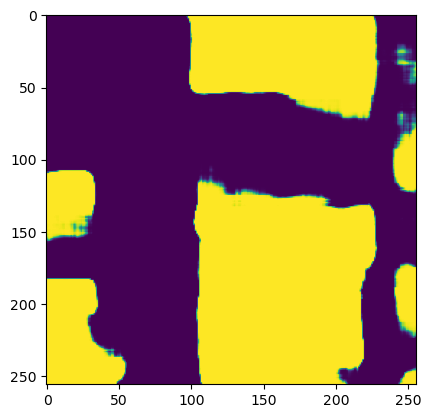

In [153]:
plt.imshow(simple_pred_photo[8])

### VGG16 model evaluation and prediction VS true Prediction

In [116]:
VGG16_model_load.evaluate(testing_dataset)

500/500 [==============================] - 150s 300ms/step - loss: 1.3622 - binary_io_u_4: 0.6774 - accuracy: 0.9338


[1.3622249364852905, 0.6774330735206604, 0.9337890148162842]

In [148]:
pred_photo = VGG16_model_load.predict(X)

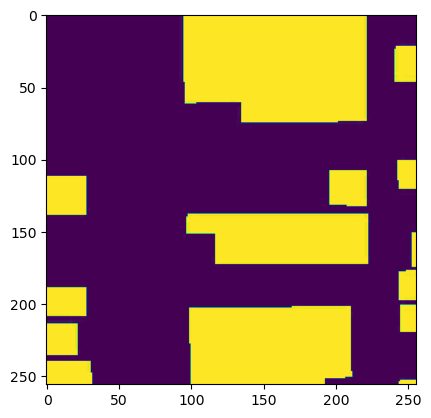

In [146]:
plt.imshow(y[8])

In [126]:
np.max(pred_photo[0])

5.5622525e-07

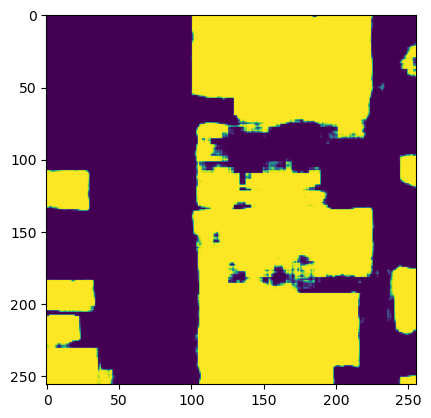

In [149]:
plt.imshow(pred_photo[8])

## Reading the test image as 1 mega image and do prediction and Construct the predict masks to one mega mask 

In [6]:
trial_path = '/home/jupyter/AerialImageDataset/tiled/test_256/images/sfo24_'
test01_images = []

for i in range(400):
    
    test01 = trial_path+str(i+1)+'.jpg'
    test01_images.append(test01)


In [8]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image/255


def data_generator(image_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset





In [17]:
test_image=[]

for i in range(400):
    test = read_image(test01_images[i])
    test_image.append(test)
test_image_pred = VGG16_model_load.predict(np.array(test_image))

2022-12-01 11:15:48.559507: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-12-01 11:16:07.241794: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [18]:
l=0
k=0
test_image_pred_merge = np.zeros((5120,5120,1))
for i in range(20):
    m=0
    for j in range(20):
        test_image_pred_merge[j+l:j+l+256,i+m:i+256+m]=test_image_pred[k]
        k+=1
        m+=255
    l+=255
        
    

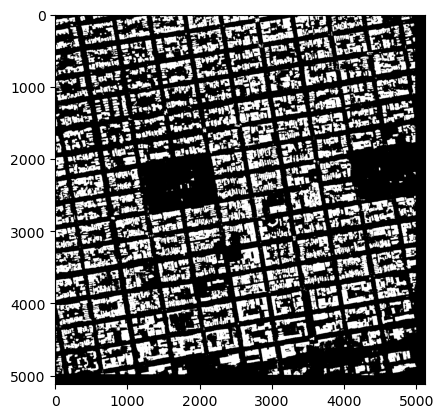

In [19]:
plt.imshow(test_image_pred_merge, cmap = 'gray')

In [20]:
l=0
k=0
test_image_merge = np.zeros((5120,5120,3))
for i in range(20):
    m=0
    for j in range(20):
        test_image_merge[j+l:j+l+256,i+m:i+256+m]=np.array(test_image)[k]
        k+=1
        m+=255
    l+=255

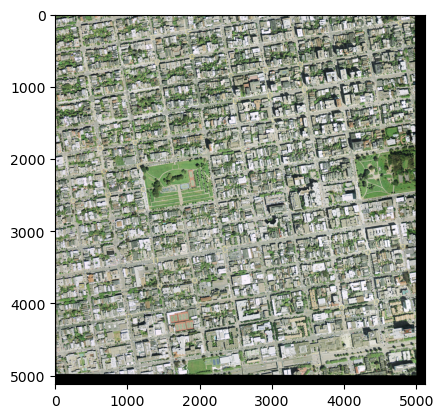

In [21]:
plt.imshow(test_image_merge, cmap = 'gray')

In [27]:
cv2.imwrite('AerialImageDataset/tiled/test_image_merg.png', test_image_merge )

False

In [9]:
pwd

'/home/jupyter/AerialImageDataset/tiled'

In [11]:
file = '../test/images/bellingham1.tif'
im = cv2.imread(file)


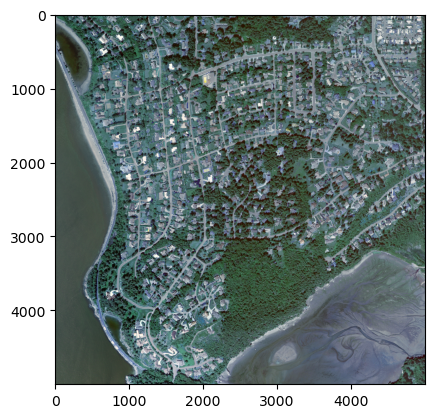

In [12]:
plt.imshow(im)

In [15]:
cv2.imwrite('/home/jupyter/AerialImageDataset/tiled/test.png', im)

True

In [61]:
def solar_roof(file):
    # checking if it is a file
    im = cv2.imread(file)
    #try:
    #im_pad = tf.image.pad_to_bounding_box(im, 0, 0, 5120, 5120)
    im_pad = np.zeros((5120,5120,3))
    im_pad[:im.shape[0],:im.shape[1],:] = im/255
    del im
    M = im_pad.shape[0]//20
    N = im_pad.shape[1]//20
    i=0
    test_image = []
    for x in range(0,im_pad.shape[0],M): 
        for y in range(0,im_pad.shape[1],N):
            tile=im_pad[x:x+M,y:y+N]
            #tf.keras.utils.save_img(f"/content/train_256/images/{file.split('/')[-1].split('.')[0]}_{i+1}.jpg", np.array(tile))
  
    test_image_pred = VGG16_model_load.predict(np.array(test_image))
    l=0
    k=0
    test_image_merge = np.zeros((5120,5120,1))
    for i in range(20):
        m=0
        for j in range(20):
            test_image_merge[j+l:j+l+256,i+m:i+256+m]=(test_image_pred)[k]
            k+=1
            m+=255
        l+=255
        
    cropped = test_image_merge[0:5000,0:5000,:]
    return cv2.imwrite(f"/home/jupyter/AerialImageDataset/tiled/cropped.png", cropped), plt.imshow(cropped, cmap = 'gray')


(True, <matplotlib.image.AxesImage at 0x7fd4821b0ed0>)

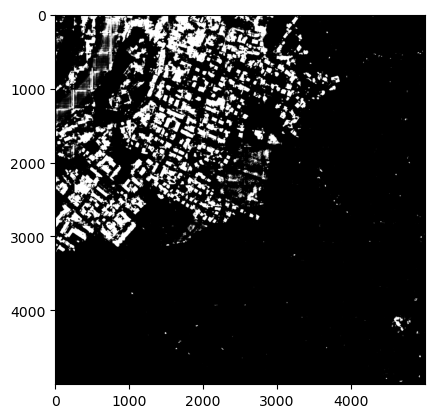

In [62]:
solar_roof('/home/jupyter/AerialImageDataset/test/images/tyrol-e20.tif')

In [ ]:
    im = cv2.imread(file)


In [45]:
test_cropped.shape

(5120, 5120, 1)

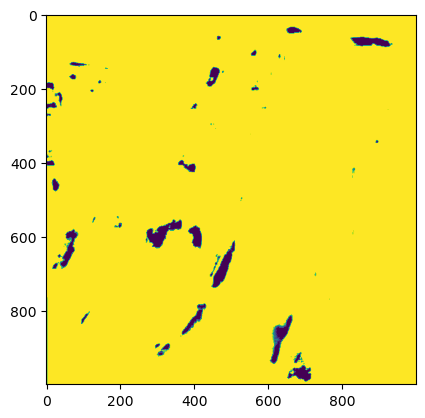

In [46]:
plt.imshow(test_cropped[0:1000, 0:1000, 0])

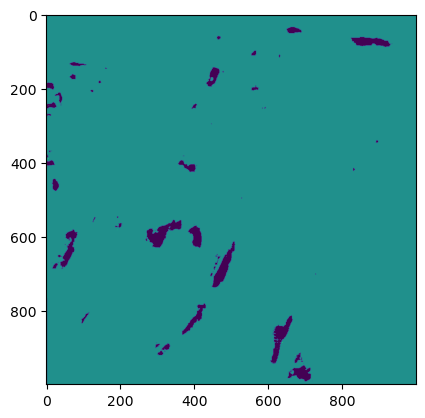

In [54]:
plt.imshow(cv2.imread('cropped.jpg')[0:1000, 0:1000, 0])

In [55]:
ls

Data_L.ipynb                       aayush.ipynb
JASS_02.ipynb                      cropped.jpg
JASS_03.ipynb                      cropped.png
JASS_04.ipynb                      first_model.h5
NoB_VGG16_iou_checkpoint_model.h5  simple_checkpoint_model.h5
NoB_VGG16_iou_model.h5             test.png
Untitled.ipynb                     test_256/
VGG16_checkpoint_model.h5          testing_256/
VGG16_iou_checkpoint_model.h5      train_256/
VGG16_iou_model.h5                 trial02.jpg
VGG16_model.h5                     trial02.png
VGG16_model_full.h5                validate_256/


In [49]:
cv2.imwrite('cropped.jpg', test_cropped)

True

In [56]:
cv2.imwrite('/home/jupyter/AerialImageDataset/shady/cropped.jpg', test_cropped)

True

In [48]:
pwd

'/home/jupyter/AerialImageDataset/tiled'

In [26]:
test_image_pred.shape

(400, 256, 256, 1)

In [32]:
test_image_merge.shape
cropped = test_image_merge[0:5000,0:5000,:]
cropped.shape

(5000, 5000, 1)

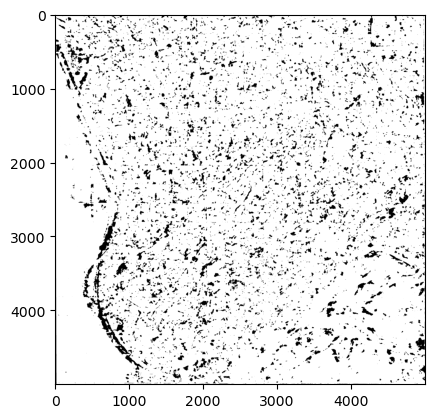

In [33]:
plt.imshow(cropped, cmap = 'gray')

In [10]:
from tensorflow.keras import layers, Model, models
import numpy as np
import cv2
import tensorflow as tf



def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)

        return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)


def solar_roof(file):
    # checking if it is a file
    im = cv2.imread(file)
    #try:
    #im_pad = tf.image.pad_to_bounding_box(im, 0, 0, 5120, 5120)
    im_pad = np.zeros((5120,5120,3))
    im_pad[:im.shape[0],:im.shape[1],:] = im/255
    del im
    M = im_pad.shape[0]//20
    N = im_pad.shape[1]//20
    i=0
    test_image = []
    for x in range(0,im_pad.shape[0],M): 
        for y in range(0,im_pad.shape[1],N):
            tile=im_pad[x:x+M,y:y+N]
            #tf.keras.utils.save_img(f"/content/train_256/images/{file.split('/')[-1].split('.')[0]}_{i+1}.jpg", np.array(tile))
            test_image.append(tile)
    VGG16_model_load = models.load_model('VGG16_model_full_Enhanced.h5', custom_objects={'loss': loss})
    test_image_pred = VGG16_model_load.predict(np.array(test_image))
    l=0
    k=0
    test_image_merge = np.zeros((5120,5120,1))
    for i in range(20):
        m=0
        for j in range(20):
            test_image_merge[j+l:j+l+256,i+m:i+256+m]=(test_image_pred)[k]
            k+=1
            m+=255
        l+=255
        
    cropped = np.uint8(test_image_merge[0:5000,0:5000,:]*255)
    plt.imshow(cropped, cmap = 'gray')
    # print(cropped.shape)
    # cropped_enc = cv2.imencode('.jpg', cropped)[1]
    # de = cv2.imdecode(cropped_enc,cv2.IMREAD_GRAYSCALE)
    
    cv2.imwrite(f"/home/jupyter/AerialImageDataset/tiled/predicted_mask_{file.split('/')[-1].split('.')[0]}.png", cropped)
    # return cv2.imwrite(f"/home/jupyter/AerialImageDataset/tiled/predicted_mask_{file.split('/')[-1].split('.')[0]}.png", cropped), plt.imshow(cropped, cmap = 'gray')


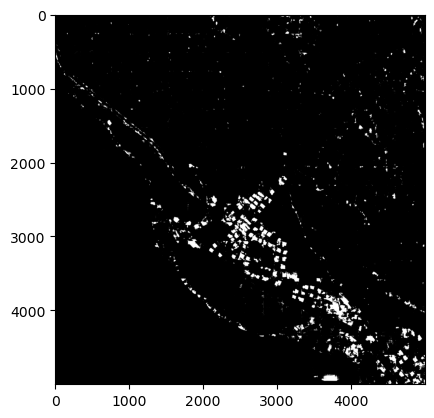

In [11]:
solar_roof('/home/jupyter/AerialImageDataset/test/images/tyrol-e21.tif')

In [34]:
Enhanced_VGG16_model_load = models.load_model('VGG16_model_full_Enhanced.h5', custom_objects={'loss': loss})


In [39]:
Enhanced_VGG16_model_load.evaluate(testing_dataset)

500/500 [==============================] - 149s 297ms/step - loss: 1.3603 - binary_io_u_2: 0.6894 - accuracy: 0.9360


[1.3603137731552124, 0.6894119381904602, 0.9359742999076843]